# Imports och Datahämtning

In [ ]:
import pandas as pd
import pandas_ta as ta
import yfinance as yf
from api import API
from datacleaner import DataCleaner
import os
import logging
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Hämtar datan från yfinance och konverterar om från multiindex.
ticker_symbols = ('GOOGL AMZN AAPL META MSFT NVDA TSLA')
start_date = '2015-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
#end_date = '2024-10-15'

api = API()
dc = DataCleaner()

raw_data = api.fetch_data(ticker_symbols, start=start_date, end=end_date)

if raw_data is not None:
    data = dc.clean_and_format_data(raw_data)



data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Felsökning: kontrollera att 'Date' är korrekt inställt som index
if 'Date' in data.columns:
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Konvertera till datetime
    data = data.dropna(subset=['Date'])  # Ta bort rader där datumkonvertering misslyckades
    data.set_index('Date', inplace=True)
else:
    print("Ingen 'Date'-kolumn hittades i 'data'. Kontrollera att datum finns.")

# Kontrollera datumintervall igen
print("Date range in data after conversion:", data.index.min(), "to", data.index.max())






In [ ]:
# ---- Hämta makrodata från FRED API ----
api_key = "TOG_BORT_MIN_API_NYCKEL"
fred_base_url = "https://api.stlouisfed.org/fred/series/observations"

def fetch_fred_data(series_id, start_date="2015-01-01", end_date="2024-12-31"):
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date
    }
    response = requests.get(fred_base_url, params=params)
    data = response.json()
    observations = data['observations']
    dates = [obs['date'] for obs in observations]
    values = [float(obs['value']) for obs in observations]
    return pd.DataFrame({"Date": dates, series_id: values}).set_index("Date")

# Hämta makroindikatorer
gdp_data = fetch_fred_data("GDP")
inflation_data = fetch_fred_data("CPIAUCSL")
interest_rate_data = fetch_fred_data("FEDFUNDS")

# Kombinera makroindikatorer
macro_data = pd.concat([gdp_data, inflation_data, interest_rate_data], axis=1).dropna()
macro_data.index = pd.to_datetime(macro_data.index)

In [ ]:
# Konvertera macro_data index till tz-naive om den är tz-aware
data.index = pd.to_datetime(data.index).tz_localize(None)
macro_data.index = pd.to_datetime(macro_data.index).tz_localize(None)

# Framåt-fyll makrodata så att kvartalsvärden sprids till alla dagar
macro_data_daily = macro_data.resample('D').ffill().bfill()

# Mergat makrodata med aktiedata igen med framåt-fylld makrodata
combined_data = data.merge(macro_data_daily, left_index=True, right_index=True, how="left")
combined_data.fillna(method='ffill', inplace=True)

# Visa de första raderna för att bekräfta att makrodata är korrekt integrerad
print(combined_data.head())


In [ ]:
# Iterera över varje ticker och beräkna tekniska indikatorer separat
grouped_data = combined_data.groupby("Ticker")

# Lista för att lagra varje ticker-data med indikatorer
ticker_frames = []

for ticker, group in grouped_data:
    # Beräkna SMA 50 och SMA 200
    group['SMA_50'] = ta.sma(group['Close'], length=50)
    group['SMA_200'] = ta.sma(group['Close'], length=200)
    
    # Beräkna RSI 14
    group['RSI_14'] = ta.rsi(group['Close'], length=14)
    
    # Beräkna EMA 8 och EMA 21
    group['EMA_8'] = ta.ema(group['Close'], length=8)
    group['EMA_21'] = ta.ema(group['Close'], length=21)
    
    # Lägg till bearbetad ticker-data till listan
    ticker_frames.append(group)

# Slå samman alla ticker-data med tekniska indikatorer till en DataFrame
final_data = pd.concat(ticker_frames)

# Visa de första raderna för att bekräfta indikatorberäkningen
print(final_data.head())

In [13]:
# Calculate daily price change and percentage change for each ticker
final_data['Price Change'] = final_data.groupby('Ticker')['Close'].diff()
final_data['% Change'] = final_data['Price Change'] / final_data.groupby('Ticker')['Close'].shift(1) * 100

# Calculate daily volatility as the difference between High and Low
final_data['Volatility'] = final_data['High'] - final_data['Low']


In [14]:
# Sparar ned dataframen
final_data.to_csv('mag7final_1101.csv')

# EDA

In [ ]:
df = pd.read_csv('mag7final.csv')

In [ ]:
df_info = df.info()
df_head = df.head()
df_describe = df.describe()

df_info, df_head, df_describe


In [ ]:
# Kontrollera saknade värden
missing_values = df.isna().sum()
print("Saknade värden per kolumn:\n", missing_values)


# Plotta fördelningen av 'Close'-priset (eller annan intressant kolumn)
plt.figure(figsize=(10, 5))
sns.histplot(df['Close'].dropna(), kde=True)
plt.title("Fördelning av det aggregerade 'Close' priser")
plt.xlabel("Close")
plt.show()

In [ ]:
# Plottar fördelningarna för de aggregerade kolumnerna
key_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'GDP', 'CPIAUCSL', 'FEDFUNDS']

plt.figure(figsize=(15, 12))
for i, column in enumerate(key_columns, 1):
    plt.subplot(4, 2, i)
    sns.histplot(df[column], kde=True)
    plt.title(f"Distribution of {column}")

plt.tight_layout()
plt.show()


In [ ]:
# Filtrerar bort alla kolumner som ej innehåller float64 eller int64
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix_corrected = numeric_df.corr()

# Plottar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_corrected, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Corrected Correlation Heatmap")
plt.show()


In [ ]:
# Plottar alla mag-7 bolagens egna data.
unique_tickers = df['Ticker'].unique()

plt.figure(figsize=(14, 20))
for i, ticker in enumerate(unique_tickers, 1):
    plt.subplot(len(unique_tickers), 1, i)
    ticker_data = df[df['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Close'], label=f'{ticker} Close Price')
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.title(f"Time Series of Close Price for {ticker}")
    plt.xticks(rotation=45)
    plt.legend()
    
    # Visar var 90de dag
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10))

plt.tight_layout()
plt.show()


In [ ]:


# Skapa en dictionary för att lagra korrelationsmatriser för varje variabel
correlations = {}

# Beräkna korrelation för varje variabel mellan tickers och spara i dictionaryn
for column in ['Close', 'Volume', 'High', 'Low']:  # Justera variabler efter vad som finns i ditt data
    ticker_data = df.pivot_table(values=column, index=df['Date'], columns='Ticker')
    correlations[column] = ticker_data.corr()

# Konvertera till en DataFrame och ta medelvärdet över alla variabler
average_correlation = sum(correlations.values()) / len(correlations)

# Plotta den genomsnittliga korrelationsmatrisen
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(average_correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Genomsnittlig korrelation mellan tickers baserat på alla variabler")
plt.show()


# Byggnation av modeller

In [18]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

# Sätt slumpfrö för reproducerbarhet
np.random.seed(42)
tf.random.set_seed(42)

# Läs in data
data = pd.read_csv('mag7final.csv')
data['Date'] = pd.to_datetime(data['Date'])
ticker = 'AAPL'  # En av de mag7 bolagen, kan bytas mellan här
data_ticker = data[data['Ticker'] == ticker]

# Skala data och skapa sekvenser för den fullständiga variabeluppsättningen
skalare_full = MinMaxScaler()
data_ticker_skalerad_full = skalare_full.fit_transform(data_ticker[['Close']])
sekvens_len = 15

# Funktion för att skapa sekvenser
def skapa_sekvenser(data, sekvens_len=15):
    X, y = [], []
    for i in range(len(data) - sekvens_len):
        X.append(data[i:i + sekvens_len])
        y.append(data[i + sekvens_len])
    return np.array(X), np.array(y)

# Skapa tränings- och testdata
X_full, y_full = skapa_sekvenser(data_ticker_skalerad_full, sekvens_len)
delningspunkt = int(0.8 * len(X_full))
X_traning_full, X_test_full = X_full[:delningspunkt], X_full[delningspunkt:]
y_traning_full, y_test_full = y_full[:delningspunkt], y_full[delningspunkt:]

# Bygg och träna LSTM-modell (Full Feature Set)
lstm_modell_full = Sequential([
    LSTM(50, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(X_traning_full.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])
lstm_modell_full.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Bygg och träna GRU-modell (Full Feature Set)
gru_modell_full = Sequential([
    GRU(50, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(X_traning_full.shape[1], 1)),
    Dropout(0.2),
    GRU(50, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])
gru_modell_full.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Träna LSTM och GRU-modeller (Full Feature Set)
lstm_modell_full.fit(X_traning_full, y_traning_full, epochs=64, batch_size=32, validation_data=(X_test_full, y_test_full), verbose=1, callbacks=[early_stopping])
gru_modell_full.fit(X_traning_full, y_traning_full, epochs=64, batch_size=32, validation_data=(X_test_full, y_test_full), verbose=1, callbacks=[early_stopping])

# Förutsägelser på testdata (Full Feature Set)
forutsagelser_lstm_full = skalare_full.inverse_transform(lstm_modell_full.predict(X_test_full)).flatten()
forutsagelser_gru_full = skalare_full.inverse_transform(gru_modell_full.predict(X_test_full)).flatten()
verkliga_test_full = skalare_full.inverse_transform(y_test_full.reshape(-1, 1)).flatten()

# Prognos för de kommande 15 dagarna
senaste_sekvensen_full = X_test_full[-1]
prognos_dagar = 15

# Iterativ prognosfunktion
def iterativ_prognos(modell, senaste_sekvens, dagar, skalare):
    prognos = []
    aktuell_sekvens = senaste_sekvens
    for _ in range(dagar):
        förutsägelse = modell.predict(aktuell_sekvens.reshape(1, -1, 1))[0][0]
        prognos.append(skalare.inverse_transform([[förutsägelse]])[0][0])
        aktuell_sekvens = np.append(aktuell_sekvens[1:], förutsägelse).reshape(-1, 1)
    return prognos

# Prognoser för LSTM och GRU-modeller (Full Feature Set)
lstm_prognos_full = iterativ_prognos(lstm_modell_full, senaste_sekvensen_full, prognos_dagar, skalare_full)
gru_prognos_full = iterativ_prognos(gru_modell_full, senaste_sekvensen_full, prognos_dagar, skalare_full)

# Beräkna RMSE för modellerna med full variabeluppsättning
rmse_lstm_full = np.sqrt(np.mean((forutsagelser_lstm_full - verkliga_test_full) ** 2))
rmse_gru_full = np.sqrt(np.mean((forutsagelser_gru_full - verkliga_test_full) ** 2))





Epoch 1/64


C:\Users\Umut_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0946 - val_loss: 0.0366
Epoch 2/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0284 - val_loss: 0.0154
Epoch 3/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0088
Epoch 4/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0058
Epoch 5/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0057 - val_loss: 0.0050
Epoch 6/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 7/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 8/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0029 - val_loss: 0.0053
Epoch 9/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0032
Epoch 10/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 11/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 12/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - val_loss: 0.0020


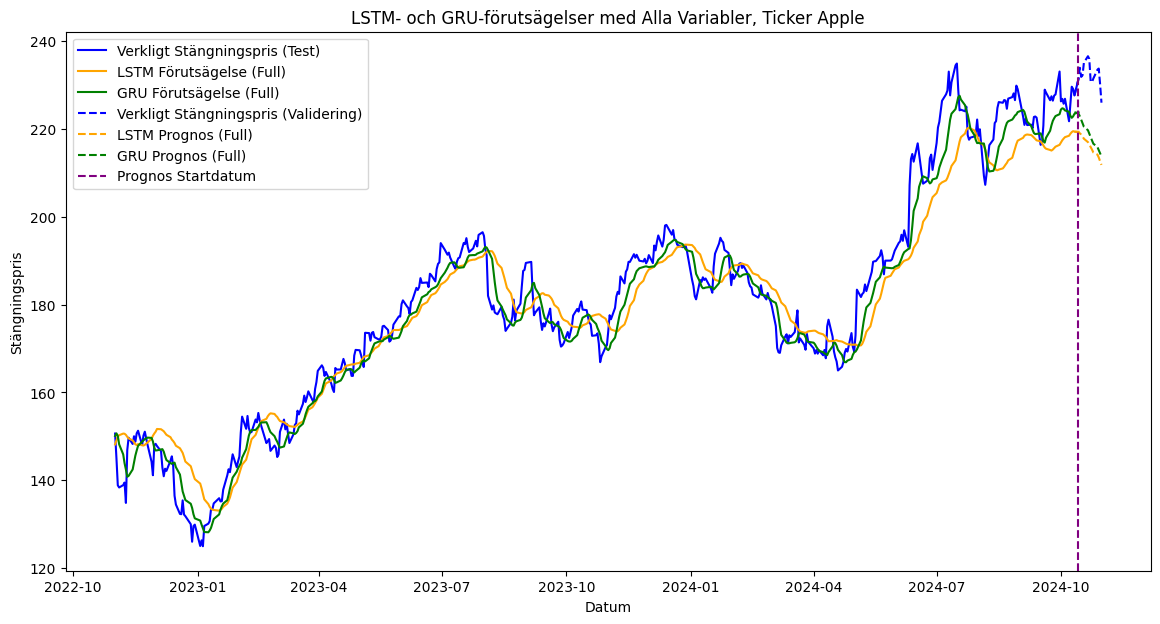

In [19]:
# Läs in valideringsdata
validerings_data = pd.read_csv('mag7final_1101.csv')
validerings_data['Date'] = pd.to_datetime(validerings_data['Date'])
validerings_ticker = validerings_data[validerings_data['Ticker'] == ticker]

# Ta bara de sista 15 dagarna av 'Close' för valideringsperioden
verklig_validering_full = validerings_ticker['Close'].values[-prognos_dagar:]
prognos_datum_full = validerings_ticker['Date'].values[-prognos_dagar:]  # Matcha med de sista 15 datumen

# Datum för den vertikala linjen
prognos_start_datum = datetime.strptime('2024-10-14', '%Y-%m-%d')

# Plottning för fulla variabler ("Full Feature Set")
plt.figure(figsize=(14, 7))

# Plot verklig testdata
test_datum_full = data_ticker['Date'].iloc[sekvens_len + delningspunkt:].values
plt.plot(test_datum_full, verkliga_test_full, label="Verkligt Stängningspris (Test)", color="blue")
plt.plot(test_datum_full, forutsagelser_lstm_full, label="LSTM Förutsägelse (Full)", color="orange")
plt.plot(test_datum_full, forutsagelser_gru_full, label="GRU Förutsägelse (Full)", color="green")

# Plot valideringsprognos och verklig data
plt.plot(prognos_datum_full, verklig_validering_full, label="Verkligt Stängningspris (Validering)", color="blue", linestyle="--")
plt.plot(prognos_datum_full, lstm_prognos_full, label="LSTM Prognos (Full)", color="orange", linestyle="--")
plt.plot(prognos_datum_full, gru_prognos_full, label="GRU Prognos (Full)", color="green", linestyle="--")

# Lägg till den vertikala linjen vid prognosens startdatum
plt.axvline(prognos_start_datum, color='purple', linestyle='--', label="Prognos Startdatum")

plt.xlabel("Datum")
plt.ylabel("Stängningspris")
plt.title("LSTM- och GRU-förutsägelser med Alla Variabler, Ticker Apple")
plt.legend()
plt.show()

# Byggnation av modeller - endast ett par variabler

In [20]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

# Sätt slumpfrö för reproducerbarhet
np.random.seed(42)
tf.random.set_seed(42)

# Använd reducerade variabler
reducerade_features = ['Date', 'EMA_8', 'SMA_50', 'SMA_200', 'Volatility', 'GDP', 'CPIAUCSL', 'Close']
data_ticker_reducerad = data_ticker[reducerade_features]

# Skala data och skapa sekvenser för den reducerade variabeluppsättningen
skalare_reducerad = MinMaxScaler()
data_ticker_skalerad_reducerad = skalare_reducerad.fit_transform(data_ticker_reducerad[['Close']])
sekvens_len = 15

# Skapa tränings- och testdata
def skapa_sekvenser(data, sekvens_len=15):
    X, y = [], []
    for i in range(len(data) - sekvens_len):
        X.append(data[i:i + sekvens_len])
        y.append(data[i + sekvens_len])
    return np.array(X), np.array(y)

X_reducerad, y_reducerad = skapa_sekvenser(data_ticker_skalerad_reducerad, sekvens_len)
delningspunkt = int(0.8 * len(X_reducerad))
X_traning_reducerad, X_test_reducerad = X_reducerad[:delningspunkt], X_reducerad[delningspunkt:]
y_traning_reducerad, y_test_reducerad = y_reducerad[:delningspunkt], y_reducerad[delningspunkt:]

# Bygg och träna LSTM-modell (Reduced Feature Set)
lstm_modell_reducerad = Sequential([
    LSTM(50, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(X_traning_reducerad.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])
lstm_modell_reducerad.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Bygg och träna GRU-modell (Reduced Feature Set)
gru_modell_reducerad = Sequential([
    GRU(50, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(X_traning_reducerad.shape[1], 1)),
    Dropout(0.2),
    GRU(50, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1)
])
gru_modell_reducerad.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Träna LSTM och GRU-modeller (Reduced Feature Set)
lstm_modell_reducerad.fit(X_traning_reducerad, y_traning_reducerad, epochs=64, batch_size=32, validation_data=(X_test_reducerad, y_test_reducerad), verbose=1, callbacks=[early_stopping])
gru_modell_reducerad.fit(X_traning_reducerad, y_traning_reducerad, epochs=64, batch_size=32, validation_data=(X_test_reducerad, y_test_reducerad), verbose=1, callbacks=[early_stopping])

# Förutsägelser på testdata (Reduced Feature Set)
forutsagelser_lstm_reducerad = skalare_reducerad.inverse_transform(lstm_modell_reducerad.predict(X_test_reducerad)).flatten()
forutsagelser_gru_reducerad = skalare_reducerad.inverse_transform(gru_modell_reducerad.predict(X_test_reducerad)).flatten()
verkliga_test_reducerad = skalare_reducerad.inverse_transform(y_test_reducerad.reshape(-1, 1)).flatten()

# Prognos för de kommande 15 dagarna (Reduced Feature Set)
senaste_sekvensen_reducerad = X_test_reducerad[-1]
prognos_dagar = 15

# Iterativ prognosfunktion
def iterativ_prognos(modell, senaste_sekvens, dagar, skalare):
    prognos = []
    aktuell_sekvens = senaste_sekvens
    for _ in range(dagar):
        förutsägelse = modell.predict(aktuell_sekvens.reshape(1, -1, 1))[0][0]
        prognos.append(skalare.inverse_transform([[förutsägelse]])[0][0])
        aktuell_sekvens = np.append(aktuell_sekvens[1:], förutsägelse).reshape(-1, 1)
    return prognos

# Prognoser för LSTM och GRU-modeller (Reduced Feature Set)
lstm_prognos_reducerad = iterativ_prognos(lstm_modell_reducerad, senaste_sekvensen_reducerad, prognos_dagar, skalare_reducerad)
gru_prognos_reducerad = iterativ_prognos(gru_modell_reducerad, senaste_sekvensen_reducerad, prognos_dagar, skalare_reducerad)

# Beräkna RMSE för modellerna med reducerad variabeluppsättning
rmse_lstm_reducerad = np.sqrt(np.mean((forutsagelser_lstm_reducerad - verkliga_test_reducerad) ** 2))
rmse_gru_reducerad = np.sqrt(np.mean((forutsagelser_gru_reducerad - verkliga_test_reducerad) ** 2))





Epoch 1/64


C:\Users\Umut_\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0944 - val_loss: 0.0324
Epoch 2/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - val_loss: 0.0145
Epoch 3/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - val_loss: 0.0087
Epoch 4/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 5/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0049
Epoch 6/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 7/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 9/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0046
Epoch 10/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 11/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0040
Epoch 1/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0877 - val_loss: 0.0376
E

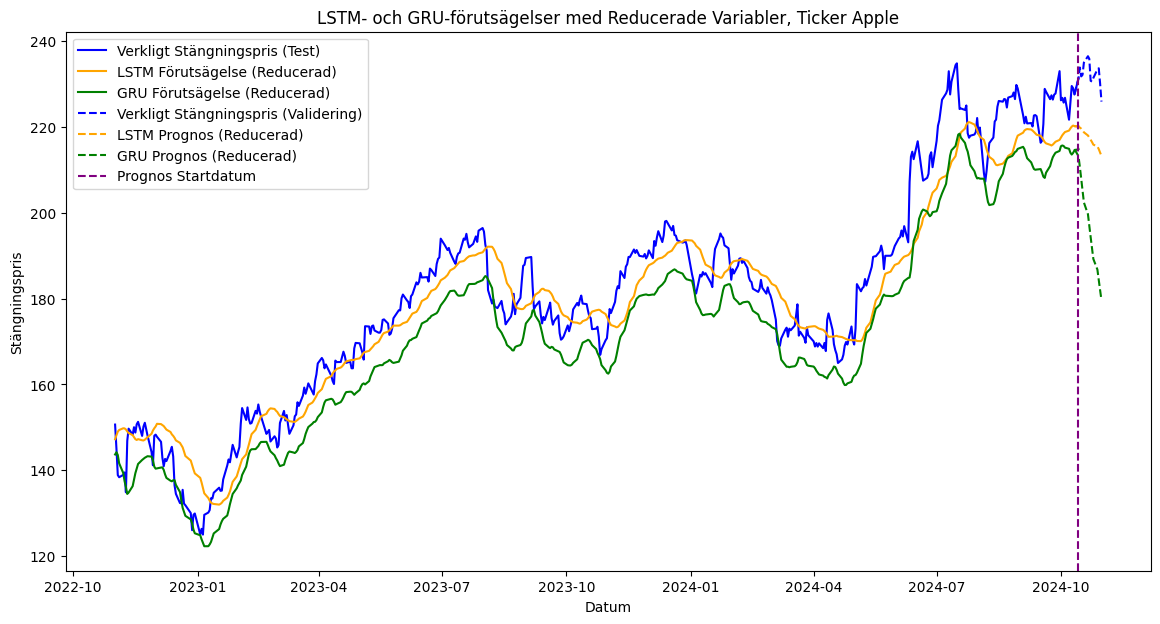

In [21]:
# Läs in valideringsdata
validerings_data = pd.read_csv('mag7final_1101.csv')
validerings_data['Date'] = pd.to_datetime(validerings_data['Date'])
validerings_ticker = validerings_data[validerings_data['Ticker'] == ticker]

# Ta bara de sista 15 dagarna av 'Close' för valideringsperioden
verklig_validering_reducerad = validerings_ticker['Close'].values[-prognos_dagar:]
prognos_datum_reducerad = validerings_ticker['Date'].values[-prognos_dagar:]  # Matcha med de sista 15 datumen

# Datum för den vertikala linjen
prognos_start_datum = datetime.strptime('2024-10-14', '%Y-%m-%d')

# Plottning för reducerade variabler ("Reduced Feature Set")
plt.figure(figsize=(14, 7))

# Plot verklig testdata
test_datum_reducerad = data_ticker['Date'].iloc[sekvens_len + delningspunkt:].values
plt.plot(test_datum_reducerad, verkliga_test_reducerad, label="Verkligt Stängningspris (Test)", color="blue")
plt.plot(test_datum_reducerad, forutsagelser_lstm_reducerad, label="LSTM Förutsägelse (Reducerad)", color="orange")
plt.plot(test_datum_reducerad, forutsagelser_gru_reducerad, label="GRU Förutsägelse (Reducerad)", color="green")

# Plot valideringsprognos och verklig data
plt.plot(prognos_datum_reducerad, verklig_validering_reducerad, label="Verkligt Stängningspris (Validering)", color="blue", linestyle="--")
plt.plot(prognos_datum_reducerad, lstm_prognos_reducerad, label="LSTM Prognos (Reducerad)", color="orange", linestyle="--")
plt.plot(prognos_datum_reducerad, gru_prognos_reducerad, label="GRU Prognos (Reducerad)", color="green", linestyle="--")

# Lägg till den vertikala linjen vid prognosens startdatum
plt.axvline(prognos_start_datum, color='purple', linestyle='--', label="Prognos Startdatum")

plt.xlabel("Datum")
plt.ylabel("Stängningspris")
plt.title("LSTM- och GRU-förutsägelser med Reducerade Variabler, Ticker Apple")
plt.legend()
plt.show()

In [23]:
# Printar med två decimaler, .2f
print(
    f"RMSE för GRU-modellen med alla variabler: {rmse_gru_full:.2f}\n"
    f"RMSE för GRU-modellen med reducerade variabler: {rmse_gru_reducerad:.2f}\n"
    f"RMSE för LSTM-modellen med alla variabler: {rmse_lstm_full:.2f}\n"
    f"RMSE för LSTM-modellen med reducerade variabler: {rmse_lstm_reducerad:.2f}\n"
)


RMSE för GRU-modellen med alla variabler: 4.78
RMSE för GRU-modellen med reducerade variabler: 10.30
RMSE för LSTM-modellen med alla variabler: 7.46
RMSE för LSTM-modellen med reducerade variabler: 7.38

